# 원, 삼각형, 사각형 구분하기
- 어려운 테스트 문제를 데이터 부풀리기를 이용하여 데이터를 많이 생성
- 기존 CNN 모델을 사용

In [1]:
from google.colab import files
up = files.upload()

Saving hard_handwriting_shape.zip to hard_handwriting_shape.zip


In [2]:
!unzip hard_handwriting_shape.zip -d hard_handwriting_shape > /dev/null

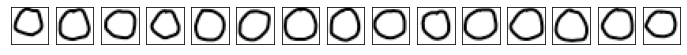

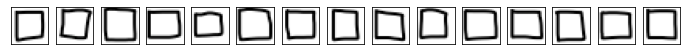

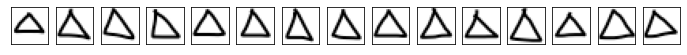

In [3]:
from PIL import Image
import glob
import matplotlib.pyplot as plt

shapes = ['circle', 'rectangle', 'triangle']
for shape in shapes:
    dir_name = f'hard_handwriting_shape/train/{shape}'
    plt.figure(figsize=(12,1))
    
    for i, fname in enumerate(glob.glob(f'{dir_name}/*.png')):
        img = Image.open(fname)
        plt.subplot(1,15,i+1), plt.imshow(img), plt.xticks([]), plt.yticks([])
    plt.show()

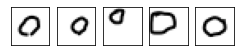

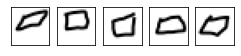

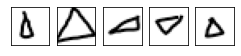

In [4]:
shapes = ['circle', 'rectangle', 'triangle']
for shape in shapes:
    dir_name = f'hard_handwriting_shape/test/{shape}'
    plt.figure(figsize=(4,1))
    
    for i, fname in enumerate(glob.glob(f'{dir_name}/*.png')):
        img = Image.open(fname)
        plt.subplot(1,5,i+1), plt.imshow(img), plt.xticks([]), plt.yticks([])
    plt.show()

In [5]:
import cv2
cv2.imread(fname).shape

(24, 24, 3)

- 데이터셋 생성하기
    - 참고: https://hidden-loca.tistory.com/18

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1/255.,                 # rescale=None, 이미지 처리 마지막에 주어진 값을 곱해 크기를 조정합니다.
    rotation_range=15,              # 정수범위 만큼 무작위로 회전
    width_shift_range=0.1,          # 사진을 좌우로 이동시킵니다. 0이하 일땐 전체의 비율, 0이상일땐 픽셀단위
    height_shift_range=0.1,         # 상하로 이동합니다. 0이하일땐 전체 비율, 1이상일땐 픽셀단위로 움직입니다.
    shear_range=0.5,                # 이미지를 찌그러 트립니다. 회전이 아님에 주의 합니다.
    zoom_range=[0.8, 2.0],          # 이미지를 확대 혹은 축소합니다. 부동소수점, 혹은 상한 하한선을 정해서 사용
    horizontal_flip=True,           # horizontal_flip=False,  좌우로 뒤집습니다, 무작위로 시행
    vertical_flip=True,             # vertical_flip=False, 상하로 뒤집습니다.
    fill_mode='nearest',            # 회전 축소 등으로 이미지에 여백이생겼을때 채우는 방법                    
)

In [7]:
# img_to_array, load_img를 이용해 쉽게 Test, Valid 이미지를 나눌 수 있다.
from tensorflow.keras.preprocessing.image import img_to_array, load_img
img = load_img('hard_handwriting_shape/train/triangle/triangle001.png')
x = img_to_array(img)
x = x.reshape((1,) + x.shape)
x.shape

(1, 24, 24, 3)

- 데이터 부풀리기를 통하여 만들어지는 새로운 도형 이미지

In [8]:
import os
if not os.path.exists('preview'):
    os.mkdir('preview')

In [9]:
count = 0
for _ in train_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='tri'):   # flow_from_directory(): file에서 불러오기 
    count += 1                                                                            # flow():메모리에서 만든 것 불러오기
    if count >= 30:
        break

In [ ]:
# !rm -rf preview       생성된 디렉토리 삭제하는 코드

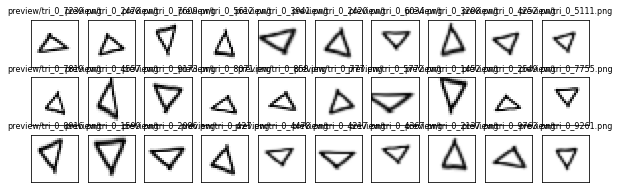

In [10]:
plt.figure(figsize=(10,3))
for i, fname in enumerate(glob.glob('preview/*.png')):
    img = Image.open(fname)
    plt.subplot(3,10,i+1)
    plt.imshow(img), plt.title(fname, size=8), plt.xticks([]), plt.yticks([])
plt.show() 

In [11]:
train_data_generator = train_datagen.flow_from_directory(
    'hard_handwriting_shape/train', 
    target_size=(24,24),
    batch_size=3,
    class_mode='categorical'
)

Found 45 images belonging to 3 classes.


In [12]:
test_datagen = ImageDataGenerator(rescale=1/255.)
test_data_generator = test_datagen.flow_from_directory(
    'hard_handwriting_shape/test', 
    target_size=(24,24),
    batch_size=3,
    class_mode='categorical'
)

Found 15 images belonging to 3 classes.


In [13]:
train_data_generator.labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2], dtype=int32)

In [14]:
train_data_generator.filenames[0]

'circle/circle001.png'

- 모델 정의/설정

In [15]:
import numpy as np
import tensorflow as tf
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [21]:
model = Sequential([ 
    Conv2D(32, (3,3), input_shape=(24,24,3), activation='relu'),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(3, activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 22, 22, 32)        896       
                                                                 
 conv2d_3 (Conv2D)           (None, 20, 20, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 6400)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               819328    
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                      

In [22]:
model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'] 
)

- 모델 학습

In [20]:
# del model

In [23]:
model.fit(
    train_data_generator,                   # 훈련데이터셋을 제공할 제너레이터
    steps_per_epoch=15,     
    epochs=300, verbose=1,
    validation_data=test_data_generator,
    validation_steps=5
)

Epoch 1/300
15/15 [==============================] - 1s 35ms/step - loss: 1.2182 - accuracy: 0.4222 - val_loss: 1.0642 - val_accuracy: 0.4667
Epoch 2/300
15/15 [==============================] - 0s 22ms/step - loss: 1.0070 - accuracy: 0.5556 - val_loss: 1.0211 - val_accuracy: 0.4000
Epoch 3/300
15/15 [==============================] - 0s 24ms/step - loss: 0.7636 - accuracy: 0.6444 - val_loss: 1.1668 - val_accuracy: 0.4667
Epoch 4/300
15/15 [==============================] - 0s 25ms/step - loss: 0.7413 - accuracy: 0.6000 - val_loss: 1.2666 - val_accuracy: 0.4667
Epoch 5/300
15/15 [==============================] - 0s 22ms/step - loss: 0.5962 - accuracy: 0.7556 - val_loss: 1.3326 - val_accuracy: 0.5333
Epoch 6/300
15/15 [==============================] - 0s 24ms/step - loss: 0.6136 - accuracy: 0.8000 - val_loss: 1.5782 - val_accuracy: 0.5333
Epoch 7/300
15/15 [==============================] - 0s 23ms/step - loss: 0.4226 - accuracy: 0.8667 - val_loss: 1.4355 - val_accuracy: 0.6000
Epoch 

- 모델 평가

In [24]:
model.evaluate(test_data_generator, steps=5)

5/5 [==============================] - 0s 5ms/step - loss: 1.4925 - accuracy: 0.7333


[1.4924871921539307, 0.7333333492279053]

In [25]:
model.evaluate(test_data_generator)

5/5 [==============================] - 0s 6ms/step - loss: 1.4925 - accuracy: 0.7333


[1.4924870729446411, 0.7333333492279053]